In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# -----------------------------
# Install required packages
# -----------------------------
!pip install timm
!pip install torchmetrics
!pip install scikit-learn


In [6]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 49.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch.geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python -c "import torch;print(torch.__version__.split('+')[0])")+cu$(python -c "import torch;print(torch.version.cuda.replace('.', ''))").html


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.0 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# =======================
# 1. Imports & Device
# =======================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool
from rdkit import Chem
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =======================
# 2. Load Datasets
# =======================
gdsc = pd.read_csv("/kaggle/input/multimodal-drug-sensitivity-prediction/GDSC_ML.csv")
meth = pd.read_csv("/kaggle/input/multimodal-drug-sensitivity-prediction/Methylation_ML.csv")
mut = pd.read_csv("/kaggle/input/multimodal-drug-sensitivity-prediction/Mutations_ML.csv")
ge = pd.read_csv("/kaggle/input/multimodal-drug-sensitivity-prediction/GE_ML.csv")

# Keep only common cell lines
common_ids = set(gdsc['depmap_id']) & set(meth['depmap_id']) & set(mut['depmap_id']) & set(ge['depmap_id'])
gdsc = gdsc[gdsc['depmap_id'].isin(common_ids)].reset_index(drop=True)
meth = meth[meth['depmap_id'].isin(common_ids)].sort_values('depmap_id').reset_index(drop=True)
mut = mut[mut['depmap_id'].isin(common_ids)].sort_values('depmap_id').reset_index(drop=True)
ge = ge[ge['depmap_id'].isin(common_ids)].sort_values('depmap_id').reset_index(drop=True)

print(f"Total samples: {len(gdsc)}")
print(f"Unique cell lines: {gdsc['depmap_id'].nunique()}")

# =======================
# 3. Prepare Cell Features with Normalization
# =======================
meth_feat = meth.drop(columns=['depmap_id']).apply(pd.to_numeric, errors='coerce').fillna(0)
mut_feat = mut.drop(columns=['depmap_id']).apply(pd.to_numeric, errors='coerce').fillna(0)
ge_feat = ge.drop(columns=['depmap_id']).apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalize features to prevent scale issues
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
meth_feat = pd.DataFrame(scaler.fit_transform(meth_feat), columns=meth_feat.columns)
mut_feat = pd.DataFrame(scaler.fit_transform(mut_feat), columns=mut_feat.columns)
ge_feat = pd.DataFrame(scaler.fit_transform(ge_feat), columns=ge_feat.columns)

cell_feat_df = pd.concat([meth_feat, mut_feat, ge_feat], axis=1)
cell_feat_df['depmap_id'] = meth['depmap_id']
print("Cell feature shape:", cell_feat_df.shape)

# =======================
# 4. Enhanced SMILES → Graph with Edge Features
# =======================
def get_atom_features(atom):
    """Enhanced atom features"""
    features = [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        atom.GetHybridization().real,
        atom.GetIsAromatic(),
        atom.GetTotalNumHs()
    ]
    return features

def get_bond_features(bond):
    """Bond type as edge feature"""
    bond_type = bond.GetBondTypeAsDouble()
    is_conjugated = bond.GetIsConjugated()
    is_in_ring = bond.IsInRing()
    return [bond_type, float(is_conjugated), float(is_in_ring)]

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Node features
    atom_features = [get_atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Edge features
    edges = []
    edge_attrs = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_feat = get_bond_features(bond)
        
        edges.append([i, j])
        edge_attrs.append(edge_feat)
        edges.append([j, i])
        edge_attrs.append(edge_feat)
    
    if len(edges) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# =======================
# 5. Dataset
# =======================
class DrugCellDataset(Dataset):
    def __init__(self, gdsc_df, cell_feat_df, max_seq_len=100):
        self.gdsc = gdsc_df.reset_index(drop=True)
        self.cell_feat_df = cell_feat_df.set_index('depmap_id')
        self.max_seq_len = max_seq_len
        
    def __len__(self):
        return len(self.gdsc)
    
    def __getitem__(self, idx):
        row = self.gdsc.iloc[idx]
        depmap_id = row['depmap_id']
        
        # Cell features
        cell_feat = torch.tensor(self.cell_feat_df.loc[depmap_id].values, dtype=torch.float)
        
        # Drug graph with edge features
        drug_graph = smiles_to_graph(row['IsomericSMILES'])
        
        # SMILES → token IDs
        smiles = row['IsomericSMILES']
        smiles_ids = torch.tensor([ord(c) for c in smiles[:self.max_seq_len]], dtype=torch.long)
        if len(smiles_ids) < self.max_seq_len:
            pad = torch.zeros(self.max_seq_len - len(smiles_ids), dtype=torch.long)
            smiles_ids = torch.cat([smiles_ids, pad], dim=0)
        
        # IC50
        ic50 = torch.tensor(row['LN_IC50'], dtype=torch.float)
        
        return cell_feat, drug_graph, smiles_ids, ic50

# Collate
def collate_fn(batch):
    cell_feats, drug_graphs, smiles_seqs, ic50s = zip(*batch)
    cell_feats = torch.stack(cell_feats)
    ic50s = torch.stack(ic50s)
    drug_graph_batch = Batch.from_data_list(drug_graphs)
    smiles_seqs = torch.stack(smiles_seqs)
    return cell_feats, drug_graph_batch, smiles_seqs, ic50s

dataset = DrugCellDataset(gdsc, cell_feat_df)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch_geometric.loader import DataLoader as GeoDataLoader
train_loader = GeoDataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)  # Larger batch
val_loader = GeoDataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# =======================
# 6. Multi-Head Attention Fusion (Compact)
# =======================
class MultiHeadAttentionFusion(nn.Module):
    def __init__(self, input_dims, hidden_dim=96, num_heads=3, dropout=0.3):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        
        # Project each modality
        self.projections = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(dropout)
            ) for dim in input_dims
        ])
        
        # Multi-head attention
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, *inputs):
        # Project all inputs
        projected = [proj(inp) for proj, inp in zip(self.projections, inputs)]
        
        # Stack: [batch, num_modalities, hidden_dim]
        x = torch.stack(projected, dim=1)
        batch_size, num_mod, _ = x.shape
        
        # Multi-head attention
        Q = self.query(x).view(batch_size, num_mod, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, num_mod, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, num_mod, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention
        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, num_mod, self.hidden_dim)
        
        # Output projection and pooling
        out = self.out_proj(context)
        out = self.norm(out + x)  # Residual
        
        # Global pooling across modalities
        out = out.mean(dim=1)
        
        return out

# =======================
# 7. Compact Model for Small Dataset
# =======================
class DrugCellModelCompact(nn.Module):
    def __init__(self, cell_feat_dim=151, hidden_dim=96, gru_hidden=48, 
                 smiles_seq_len=100, num_gine_layers=2, dropout=0.3):
        super().__init__()
        
        # Cell line encoder - simpler to avoid overfitting
        self.cell_dnn = nn.Sequential(
            nn.Linear(cell_feat_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout * 0.5)
        )
        
        # GINE layers - fewer layers for smaller dataset
        self.gine_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for i in range(num_gine_layers):
            in_dim = 7 if i == 0 else hidden_dim
            mlp = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout * 0.5)
            )
            # CRITICAL: Specify edge_dim to match edge embedding output
            self.gine_layers.append(GINEConv(mlp, edge_dim=hidden_dim, train_eps=True))
            self.batch_norms.append(nn.LayerNorm(hidden_dim))
        
        # Edge embedding
        self.edge_emb = nn.Sequential(
            nn.Linear(3, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim)
        )
        
        # BiGRU for SMILES - single layer to reduce parameters
        self.embedding = nn.Embedding(128, gru_hidden, padding_idx=0)
        self.bigru = nn.GRU(gru_hidden, gru_hidden, num_layers=1, batch_first=True, 
                            bidirectional=True, dropout=0.0)
        self.smiles_proj = nn.Sequential(
            nn.Linear(2 * gru_hidden, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        
        # Multi-head attention fusion
        self.attention_fusion = MultiHeadAttentionFusion(
            input_dims=[hidden_dim, hidden_dim, hidden_dim],
            hidden_dim=hidden_dim,
            num_heads=3,
            dropout=dropout
        )
        
        # Final predictor - compact
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, cell_feat, drug_graph_batch, smiles_seq):
        # Cell line embedding
        cell_emb = self.cell_dnn(cell_feat)
        
        # Drug graph with GINE
        x = drug_graph_batch.x
        edge_index = drug_graph_batch.edge_index
        edge_attr = self.edge_emb(drug_graph_batch.edge_attr)
        batch = drug_graph_batch.batch
        
        for i, (gine, bn) in enumerate(zip(self.gine_layers, self.batch_norms)):
            x_new = gine(x, edge_index, edge_attr)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            if i > 0:  # Residual after first layer
                x = x + x_new
            else:
                x = x_new
        
        # Dual pooling
        drug_emb = (global_mean_pool(x, batch) + global_max_pool(x, batch)) / 2
        
        # SMILES sequence embedding
        mask = (smiles_seq != 0).float().unsqueeze(-1)
        embeds = self.embedding(smiles_seq) * mask
        gru_out, _ = self.bigru(embeds)
        
        # Take last hidden state (already contains bidirectional info)
        smiles_emb = self.smiles_proj(gru_out[:, -1, :])
        
        # Attention-based fusion
        fused = self.attention_fusion(cell_emb, drug_emb, smiles_emb)
        
        # Prediction
        out = self.predictor(fused)
        return out.squeeze()

model = DrugCellModelCompact(cell_feat_dim=cell_feat_df.shape[1]-1).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# =======================
# 8. Training with Enhanced Early Stopping
# =======================
best_val_loss = np.inf
best_val_pcc = -np.inf
patience = 10
trigger_times = 0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    y_true_train, y_pred_train = [], []

    for cell_feat, drug_graph_batch, smiles_seq, ic50 in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        cell_feat = cell_feat.to(device)
        drug_graph_batch = drug_graph_batch.to(device)
        smiles_seq = smiles_seq.to(device)
        ic50 = ic50.to(device)

        optimizer.zero_grad()
        output = model(cell_feat, drug_graph_batch, smiles_seq)
        loss = criterion(output, ic50)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()

        y_true_train.extend(ic50.detach().cpu().numpy())
        y_pred_train.extend(output.detach().cpu().numpy())

    # RMSE & PCC for training
    train_rmse = mean_squared_error(y_true_train, y_pred_train, squared=False)
    train_pcc = pearsonr(y_true_train, y_pred_train)[0]

    # Validation
    model.eval()
    val_loss = 0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for cell_feat, drug_graph_batch, smiles_seq, ic50 in val_loader:
            cell_feat = cell_feat.to(device)
            drug_graph_batch = drug_graph_batch.to(device)
            smiles_seq = smiles_seq.to(device)
            ic50 = ic50.to(device)

            output = model(cell_feat, drug_graph_batch, smiles_seq)
            loss = criterion(output, ic50)
            val_loss += loss.item()

            y_true_val.extend(ic50.cpu().numpy())
            y_pred_val.extend(output.cpu().numpy())

    val_rmse = mean_squared_error(y_true_val, y_pred_val, squared=False)
    val_pcc = pearsonr(y_true_val, y_pred_val)[0]
    
    from sklearn.metrics import r2_score, mean_absolute_error
    val_r2 = r2_score(y_true_val, y_pred_val)
    val_mae = mean_absolute_error(y_true_val, y_pred_val)

    # Scheduler step
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | RMSE: {train_rmse:.4f} | PCC: {train_pcc:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | RMSE: {val_rmse:.4f} | PCC: {val_pcc:.4f} | "
          f"R²: {val_r2:.4f} | MAE: {val_mae:.4f}")

    # Early stopping based on validation PCC (better metric for correlation)
    if val_pcc > best_val_pcc:
        best_val_pcc = val_pcc
        best_val_loss = val_loss/len(val_loader)
        trigger_times = 0
        torch.save(model.state_dict(), "best_model_compact.pth")
        print(f"Best model saved (PCC: {val_pcc:.4f})")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# =======================
# 9. Final Evaluation
# =======================
model.load_state_dict(torch.load("best_model_compact.pth"))
model.eval()

y_true_final, y_pred_final = [], []
with torch.no_grad():
    for cell_feat, drug_graph_batch, smiles_seq, ic50 in val_loader:
        cell_feat = cell_feat.to(device)
        drug_graph_batch = drug_graph_batch.to(device)
        smiles_seq = smiles_seq.to(device)
        ic50 = ic50.to(device)
        
        output = model(cell_feat, drug_graph_batch, smiles_seq)
        y_true_final.extend(ic50.cpu().numpy())
        y_pred_final.extend(output.cpu().numpy())

final_rmse = mean_squared_error(y_true_final, y_pred_final, squared=False)
final_pcc = pearsonr(y_true_final, y_pred_final)[0]
final_r2 = r2_score(y_true_final, y_pred_final)
final_mae = mean_absolute_error(y_true_final, y_pred_final)

print("\n" + "="*70)
print("FINAL RESULTS ON VALIDATION SET (Best Model)")
print("="*70)
print(f"RMSE:           {final_rmse:.4f}  (Lower is better)")
print(f"MAE:            {final_mae:.4f}  (Lower is better)")
print(f"Pearson Corr:   {final_pcc:.4f}  (Higher is better, max=1.0)")
print(f"R² Score:       {final_r2:.4f}  (Higher is better, max=1.0)")


Device: cuda
Total samples: 114029
Unique cell lines: 542
Cell feature shape: (542, 151)
Total parameters: 197,866
Trainable parameters: 197,866


Epoch 1/100: 100%|██████████| 1426/1426 [01:45<00:00, 13.52it/s]


Epoch 1/100 | Train Loss: 5.5152 | RMSE: 2.3487 | PCC: 0.5570 | Val Loss: 3.4338 | RMSE: 1.8525 | PCC: 0.7683 | R²: 0.5733 | MAE: 1.4843
Best model saved (PCC: 0.7683)


Epoch 2/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.69it/s]


Epoch 2/100 | Train Loss: 3.1007 | RMSE: 1.7610 | PCC: 0.7821 | Val Loss: 2.1922 | RMSE: 1.4808 | PCC: 0.8573 | R²: 0.7273 | MAE: 1.1387
Best model saved (PCC: 0.8573)


Epoch 3/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.70it/s]


Epoch 3/100 | Train Loss: 2.2133 | RMSE: 1.4879 | PCC: 0.8501 | Val Loss: 1.7396 | RMSE: 1.3193 | PCC: 0.8876 | R²: 0.7836 | MAE: 1.0035
Best model saved (PCC: 0.8876)


Epoch 4/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.70it/s]


Epoch 4/100 | Train Loss: 1.9972 | RMSE: 1.4133 | PCC: 0.8659 | Val Loss: 1.7006 | RMSE: 1.3044 | PCC: 0.8912 | R²: 0.7884 | MAE: 0.9964
Best model saved (PCC: 0.8912)


Epoch 5/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.72it/s]


Epoch 5/100 | Train Loss: 1.8990 | RMSE: 1.3781 | PCC: 0.8729 | Val Loss: 1.5785 | RMSE: 1.2567 | PCC: 0.8970 | R²: 0.8036 | MAE: 0.9393
Best model saved (PCC: 0.8970)


Epoch 6/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.68it/s]


Epoch 6/100 | Train Loss: 1.8233 | RMSE: 1.3502 | PCC: 0.8783 | Val Loss: 1.5783 | RMSE: 1.2567 | PCC: 0.8968 | R²: 0.8036 | MAE: 0.9426


Epoch 7/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.69it/s]


Epoch 7/100 | Train Loss: 1.7731 | RMSE: 1.3316 | PCC: 0.8819 | Val Loss: 1.5458 | RMSE: 1.2435 | PCC: 0.8998 | R²: 0.8077 | MAE: 0.9247
Best model saved (PCC: 0.8998)


Epoch 8/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.74it/s]


Epoch 8/100 | Train Loss: 1.7279 | RMSE: 1.3144 | PCC: 0.8851 | Val Loss: 1.5031 | RMSE: 1.2263 | PCC: 0.9018 | R²: 0.8130 | MAE: 0.9140
Best model saved (PCC: 0.9018)


Epoch 9/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.70it/s]


Epoch 9/100 | Train Loss: 1.6975 | RMSE: 1.3029 | PCC: 0.8872 | Val Loss: 1.4931 | RMSE: 1.2222 | PCC: 0.9025 | R²: 0.8142 | MAE: 0.9093
Best model saved (PCC: 0.9025)


Epoch 10/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.73it/s]


Epoch 10/100 | Train Loss: 1.6869 | RMSE: 1.2988 | PCC: 0.8880 | Val Loss: 1.4883 | RMSE: 1.2203 | PCC: 0.9028 | R²: 0.8148 | MAE: 0.9074
Best model saved (PCC: 0.9028)


Epoch 11/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.71it/s]


Epoch 11/100 | Train Loss: 1.8442 | RMSE: 1.3582 | PCC: 0.8768 | Val Loss: 1.6039 | RMSE: 1.2668 | PCC: 0.8954 | R²: 0.8005 | MAE: 0.9534


Epoch 12/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.75it/s]


Epoch 12/100 | Train Loss: 1.8277 | RMSE: 1.3519 | PCC: 0.8780 | Val Loss: 1.6114 | RMSE: 1.2699 | PCC: 0.8953 | R²: 0.7995 | MAE: 0.9515


Epoch 13/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.74it/s]


Epoch 13/100 | Train Loss: 1.7912 | RMSE: 1.3382 | PCC: 0.8806 | Val Loss: 1.5726 | RMSE: 1.2543 | PCC: 0.8969 | R²: 0.8044 | MAE: 0.9380


Epoch 14/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.73it/s]


Epoch 14/100 | Train Loss: 1.7671 | RMSE: 1.3295 | PCC: 0.8822 | Val Loss: 1.5466 | RMSE: 1.2440 | PCC: 0.8999 | R²: 0.8076 | MAE: 0.9236


Epoch 15/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 15/100 | Train Loss: 1.7435 | RMSE: 1.3203 | PCC: 0.8840 | Val Loss: 1.5977 | RMSE: 1.2643 | PCC: 0.8968 | R²: 0.8012 | MAE: 0.9568


Epoch 16/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.71it/s]


Epoch 16/100 | Train Loss: 1.7220 | RMSE: 1.3123 | PCC: 0.8855 | Val Loss: 1.5818 | RMSE: 1.2580 | PCC: 0.9009 | R²: 0.8032 | MAE: 0.9315


Epoch 17/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 17/100 | Train Loss: 1.6944 | RMSE: 1.3017 | PCC: 0.8874 | Val Loss: 1.5320 | RMSE: 1.2378 | PCC: 0.9005 | R²: 0.8095 | MAE: 0.9183


Epoch 18/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.72it/s]


Epoch 18/100 | Train Loss: 1.6661 | RMSE: 1.2909 | PCC: 0.8894 | Val Loss: 1.5633 | RMSE: 1.2506 | PCC: 0.9008 | R²: 0.8055 | MAE: 0.9393


Epoch 19/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.72it/s]


Epoch 19/100 | Train Loss: 1.6470 | RMSE: 1.2834 | PCC: 0.8907 | Val Loss: 1.5209 | RMSE: 1.2334 | PCC: 0.9017 | R²: 0.8108 | MAE: 0.9155


Epoch 20/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.69it/s]


Epoch 20/100 | Train Loss: 1.6303 | RMSE: 1.2768 | PCC: 0.8919 | Val Loss: 1.4890 | RMSE: 1.2206 | PCC: 0.9031 | R²: 0.8147 | MAE: 0.9144
Best model saved (PCC: 0.9031)


Epoch 21/100: 100%|██████████| 1426/1426 [01:47<00:00, 13.25it/s]


Epoch 21/100 | Train Loss: 1.6125 | RMSE: 1.2699 | PCC: 0.8932 | Val Loss: 1.4794 | RMSE: 1.2163 | PCC: 0.9051 | R²: 0.8160 | MAE: 0.9113
Best model saved (PCC: 0.9051)


Epoch 22/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.73it/s]


Epoch 22/100 | Train Loss: 1.6021 | RMSE: 1.2658 | PCC: 0.8939 | Val Loss: 1.4495 | RMSE: 1.2042 | PCC: 0.9054 | R²: 0.8197 | MAE: 0.8916
Best model saved (PCC: 0.9054)


Epoch 23/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 23/100 | Train Loss: 1.5833 | RMSE: 1.2583 | PCC: 0.8952 | Val Loss: 1.4503 | RMSE: 1.2045 | PCC: 0.9057 | R²: 0.8196 | MAE: 0.8936
Best model saved (PCC: 0.9057)


Epoch 24/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.72it/s]


Epoch 24/100 | Train Loss: 1.5653 | RMSE: 1.2513 | PCC: 0.8964 | Val Loss: 1.4376 | RMSE: 1.1993 | PCC: 0.9065 | R²: 0.8211 | MAE: 0.8868
Best model saved (PCC: 0.9065)


Epoch 25/100: 100%|██████████| 1426/1426 [01:44<00:00, 13.71it/s]


Epoch 25/100 | Train Loss: 1.5573 | RMSE: 1.2479 | PCC: 0.8970 | Val Loss: 1.4345 | RMSE: 1.1979 | PCC: 0.9067 | R²: 0.8216 | MAE: 0.8883
Best model saved (PCC: 0.9067)


Epoch 26/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.72it/s]


Epoch 26/100 | Train Loss: 1.5423 | RMSE: 1.2419 | PCC: 0.8981 | Val Loss: 1.4196 | RMSE: 1.1917 | PCC: 0.9074 | R²: 0.8234 | MAE: 0.8826
Best model saved (PCC: 0.9074)


Epoch 27/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.74it/s]


Epoch 27/100 | Train Loss: 1.5346 | RMSE: 1.2389 | PCC: 0.8986 | Val Loss: 1.4185 | RMSE: 1.1913 | PCC: 0.9075 | R²: 0.8235 | MAE: 0.8810
Best model saved (PCC: 0.9075)


Epoch 28/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.73it/s]


Epoch 28/100 | Train Loss: 1.5274 | RMSE: 1.2358 | PCC: 0.8991 | Val Loss: 1.4206 | RMSE: 1.1922 | PCC: 0.9075 | R²: 0.8233 | MAE: 0.8807


Epoch 29/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 29/100 | Train Loss: 1.5303 | RMSE: 1.2371 | PCC: 0.8989 | Val Loss: 1.4153 | RMSE: 1.1899 | PCC: 0.9078 | R²: 0.8239 | MAE: 0.8795
Best model saved (PCC: 0.9078)


Epoch 30/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.75it/s]


Epoch 30/100 | Train Loss: 1.5195 | RMSE: 1.2323 | PCC: 0.8997 | Val Loss: 1.4148 | RMSE: 1.1897 | PCC: 0.9078 | R²: 0.8240 | MAE: 0.8798
Best model saved (PCC: 0.9078)


Epoch 31/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 31/100 | Train Loss: 1.6464 | RMSE: 1.2831 | PCC: 0.8908 | Val Loss: 1.5146 | RMSE: 1.2311 | PCC: 0.9015 | R²: 0.8116 | MAE: 0.9147


Epoch 32/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.75it/s]


Epoch 32/100 | Train Loss: 1.6474 | RMSE: 1.2836 | PCC: 0.8907 | Val Loss: 1.4901 | RMSE: 1.2210 | PCC: 0.9031 | R²: 0.8146 | MAE: 0.9129


Epoch 33/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.79it/s]


Epoch 33/100 | Train Loss: 1.6391 | RMSE: 1.2801 | PCC: 0.8913 | Val Loss: 1.4770 | RMSE: 1.2155 | PCC: 0.9037 | R²: 0.8163 | MAE: 0.9105


Epoch 34/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.78it/s]


Epoch 34/100 | Train Loss: 1.6294 | RMSE: 1.2762 | PCC: 0.8920 | Val Loss: 1.4813 | RMSE: 1.2173 | PCC: 0.9039 | R²: 0.8158 | MAE: 0.9090


Epoch 35/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.81it/s]


Epoch 35/100 | Train Loss: 1.6224 | RMSE: 1.2738 | PCC: 0.8925 | Val Loss: 1.4729 | RMSE: 1.2138 | PCC: 0.9038 | R²: 0.8168 | MAE: 0.9023


Epoch 36/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 36/100 | Train Loss: 1.6136 | RMSE: 1.2702 | PCC: 0.8931 | Val Loss: 1.6109 | RMSE: 1.2694 | PCC: 0.9011 | R²: 0.7996 | MAE: 0.9596


Epoch 37/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.77it/s]


Epoch 37/100 | Train Loss: 1.6132 | RMSE: 1.2698 | PCC: 0.8932 | Val Loss: 1.4739 | RMSE: 1.2143 | PCC: 0.9047 | R²: 0.8167 | MAE: 0.9070


Epoch 38/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.77it/s]


Epoch 38/100 | Train Loss: 1.5962 | RMSE: 1.2633 | PCC: 0.8943 | Val Loss: 1.4700 | RMSE: 1.2127 | PCC: 0.9045 | R²: 0.8171 | MAE: 0.8987


Epoch 39/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.76it/s]


Epoch 39/100 | Train Loss: 1.5921 | RMSE: 1.2619 | PCC: 0.8946 | Val Loss: 1.4603 | RMSE: 1.2086 | PCC: 0.9054 | R²: 0.8184 | MAE: 0.9014


Epoch 40/100: 100%|██████████| 1426/1426 [01:43<00:00, 13.77it/s]


Epoch 40/100 | Train Loss: 1.5829 | RMSE: 1.2583 | PCC: 0.8952 | Val Loss: 1.4775 | RMSE: 1.2157 | PCC: 0.9041 | R²: 0.8162 | MAE: 0.9047
Early stopping at epoch 40

FINAL RESULTS ON VALIDATION SET (Best Model)
RMSE:           1.1897  (Lower is better)
MAE:            0.8798  (Lower is better)
Pearson Corr:   0.9078  (Higher is better, max=1.0)
R² Score:       0.8240  (Higher is better, max=1.0)


In [9]:
import random

# =======================
# Show Random IC50 Predictions
# =======================
y_true_tensor = torch.tensor(y_true_final)
y_pred_tensor = torch.tensor(y_pred_final)

# Pick random sample indices
num_samples = 10  # you can change to any number
indices = random.sample(range(len(y_true_tensor)), num_samples)

print("\nSample IC50 Predictions (True vs Predicted):")
print("-" * 60)
for i in indices:
    true_val = y_true_tensor[i].item()
    pred_val = y_pred_tensor[i].item()
    abs_err = abs(true_val - pred_val)
    print(f"True: {true_val:.4f} \t Pred: {pred_val:.4f} \t |Error|: {abs_err:.4f}")
print("-" * 60)



Sample IC50 Predictions (True vs Predicted):
------------------------------------------------------------
True: 4.4252 	 Pred: 4.6585 	 |Error|: 0.2333
True: 1.6906 	 Pred: 1.9638 	 |Error|: 0.2732
True: -0.5058 	 Pred: 1.5936 	 |Error|: 2.0994
True: 1.5884 	 Pred: 0.4522 	 |Error|: 1.1362
True: 3.2627 	 Pred: 3.5485 	 |Error|: 0.2859
True: -2.8616 	 Pred: 0.4352 	 |Error|: 3.2968
True: 3.0911 	 Pred: 3.4753 	 |Error|: 0.3842
True: 4.8207 	 Pred: 3.2672 	 |Error|: 1.5535
True: 0.0905 	 Pred: -1.1746 	 |Error|: 1.2651
True: 4.6571 	 Pred: 3.2946 	 |Error|: 1.3625
------------------------------------------------------------


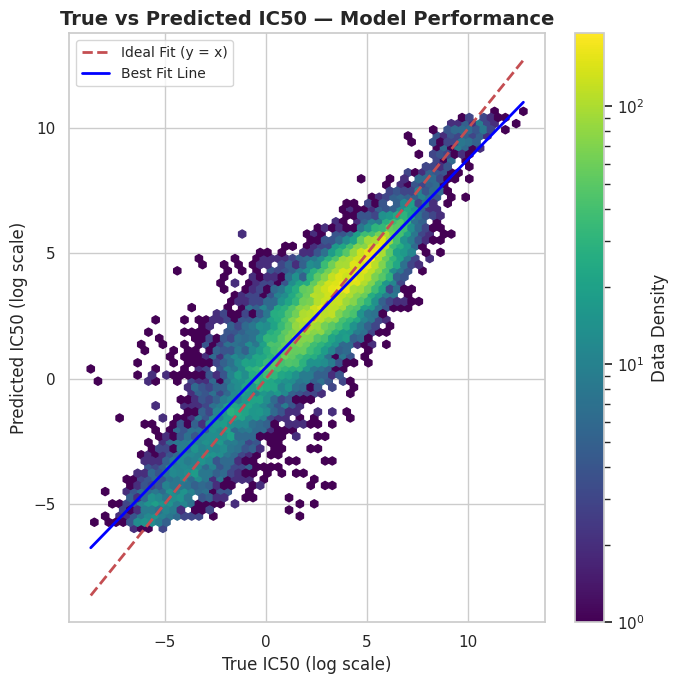

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Convert to numpy
y_true_np = np.array(y_true_final)
y_pred_np = np.array(y_pred_final)

# Setup figure
plt.figure(figsize=(7,7))
sns.set(style="whitegrid")

# Use seaborn hexbin/kde-like scatter for density visualization
plt.hexbin(
    y_true_np, y_pred_np,
    gridsize=60, cmap="viridis", bins='log', mincnt=1
)

# Add ideal and regression lines
min_val = min(y_true_np.min(), y_pred_np.min())
max_val = max(y_true_np.max(), y_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit (y = x)')

coef = np.polyfit(y_true_np, y_pred_np, 1)
poly1d_fn = np.poly1d(coef)
plt.plot([min_val, max_val], poly1d_fn([min_val, max_val]), color='blue', lw=2, label='Best Fit Line')

# Labels and aesthetics
plt.xlabel("True IC50 (log scale)", fontsize=12)
plt.ylabel("Predicted IC50 (log scale)", fontsize=12)
plt.title("True vs Predicted IC50 — Model Performance", fontsize=14, weight='bold')
plt.legend(fontsize=10)
plt.colorbar(label='Data Density')
plt.tight_layout()
plt.show()


In [ ]:
plt.scatter(y_true_final, y_pred_final, alpha=0.6)
plt.plot([min(y_true_final), max(y_true_final)], [min(y_true_final), max(y_true_final)], 'r--', label='Ideal (y=x)')
plt.plot(y_true_final, 0.832*y_true_final + 0.453, 'g-', label='Best Fit')
plt.legend()
plt.xlabel('True IC50')
plt.ylabel('Predicted IC50')
plt.title('IC50 Prediction Calibration')
plt.show()


In [3]:
import os
import json
import pandas as pd
import numpy as np
import torch

# =======================
# 10. Save Results for Backend / Reuse
# =======================

# Convert all numeric values to Python float safely
def make_serializable(obj):
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    elif isinstance(obj, torch.Tensor):
        return obj.item()
    elif isinstance(obj, float):
        return round(obj, 4)
    else:
        return obj

# ---- Final evaluation metrics ----
results = {
    "RMSE": make_serializable(final_rmse),
    "MAE": make_serializable(final_mae),
    "PearsonCorr": make_serializable(final_pcc),
    "R2_Score": make_serializable(final_r2),
    "Best_Val_PCC": make_serializable(best_val_pcc),
    "Best_Val_Loss": make_serializable(best_val_loss),
    "Epochs_Ran": int(epoch + 1)
}

# Save final metrics as JSON
with open("/kaggle/working/final_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("\nSaved final metrics → /kaggle/working/final_results.json")

# ---- Save predictions ----
pred_df = pd.DataFrame({
    "True_IC50": [float(x) for x in y_true_final],
    "Predicted_IC50": [float(x) for x in y_pred_final]
})
pred_df.to_csv("/kaggle/working/predictions.csv", index=False)
print("Saved predictions → /kaggle/working/predictions.csv")

# ---- Save best model weights ----
if os.path.exists("best_model_compact.pth"):
    os.rename("best_model_compact.pth", "/kaggle/working/best_model_compact.pth")
    print("Best model moved → /kaggle/working/best_model_compact.pth")
else:
    print("No best_model_compact.pth found — skipping move.")

# ---- Save short training summary ----
log_data = {
    "training_RMSE": make_serializable(train_rmse),
    "training_PCC": make_serializable(train_pcc)
}
with open("/kaggle/working/training_summary.json", "w") as f:
    json.dump(log_data, f, indent=4)
print("Training summary saved → /kaggle/working/training_summary.json")

print("\nAll backend files saved successfully!")



Saved final metrics → /kaggle/working/final_results.json
Saved predictions → /kaggle/working/predictions.csv
Best model moved → /kaggle/working/best_model_compact.pth
Training summary saved → /kaggle/working/training_summary.json

All backend files saved successfully!
